In [1]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
# Distribution functions
from scipy.stats import norm

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

C:\Users\antho\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\antho\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

risk_free_rate = 0.05

In [5]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity + true_beta *np.square(moneyness - 1)

In [6]:
def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

Time to maturity (Ts) is generated using np.random.random function which generates a uniform random variable between 0 & 1\
Moneyness (Ks) is generated using np.random.randn which generates a normally distributed random variable. The random number multiplied by 0.25 generates a deviation of strike from spot price. Overall equation ensures that the moneyness is greater than 0\
Volatility (sigma) is generated as a function of time to maturity and moneyness\
Option price (Ps) is generated for the Black-Scholes option price

In [7]:
N = 10000

Ks = 1+0.25*np.random.randn(N)
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

Now we create the Predicted and Predictor variables

In [8]:
Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

In [9]:
dataset.head()

,Price,Moneyness,Time,Vol
0,0.007419,1.278617,0.243801,0.232143
1,0.117884,0.883491,0.030478,0.204405
2,0.125574,1.133579,0.629372,0.264722
3,0.000038,1.245688,0.077126,0.213749
4,0.006306,1.269769,0.224899,0.229767


In [10]:
dataset.describe()

,Price,Moneyness,Time,Vol
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.178935,0.998967,0.500168,0.256346
std,0.135815,0.251597,0.289560,0.030266
min,0.000000,0.109901,0.000100,0.200031
25%,0.075105,0.826937,0.249003,0.231096
50%,0.160738,1.000553,0.498986,0.256146
75%,0.254355,1.167952,0.750749,0.281603
max,0.893314,1.944539,0.999688,0.374242


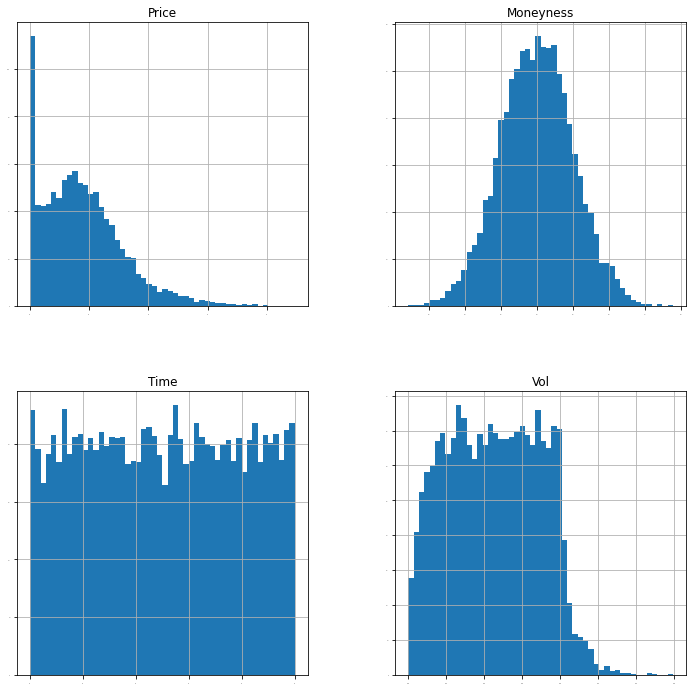

In [11]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

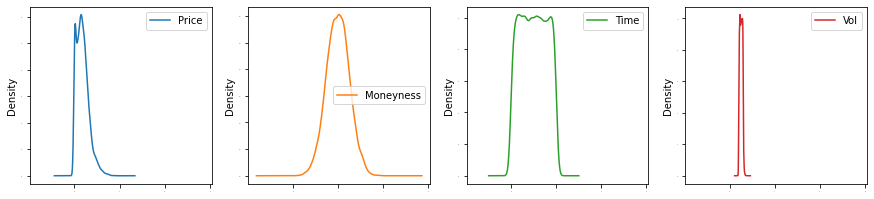

In [12]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

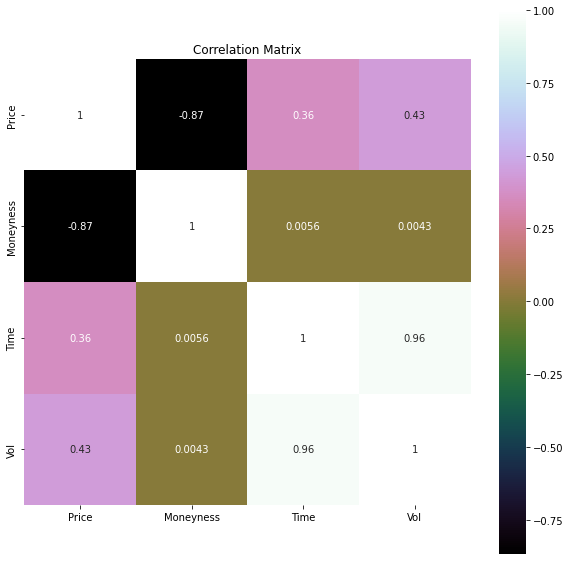

In [13]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

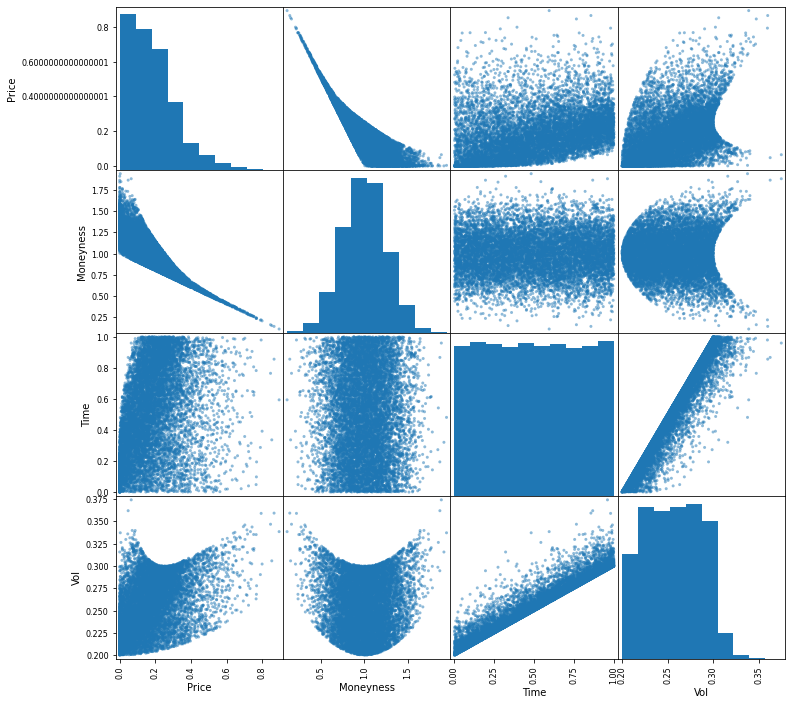

In [14]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

moneyness decreases (i.e., strike price decreases as compared to the stock price) as price increases\
price versus time: we see an increase in the option price\
price vs volatility: increase of price with the volatility\
option price seems to exhibit a nonlinear relationship with most of the variable\
volatility and strike: The more we deviate from the moneyness of one, the higher the volatility

In [15]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,30499.486930
Vol,2318.729033
Time,1473.184709


Train-test split and evaluate metrics

In [16]:
validation_size = 0.2

train_size = int(len(X)*(1-validation_size))
X_train, Y_train = X[0:train_size], Y[0:train_size]
X_test, Y_test = X[train_size:len(X)],Y[train_size:len(Y)]

In [18]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

In [19]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

models.append(('MLP', MLPRegressor()))

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [20]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=None)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000366 (0.000023) 0.000365 0.000354
LASSO: 0.018487 (0.000741) 0.018485 0.018282
EN: 0.018487 (0.000741) 0.018485 0.018282
KNN: 0.000018 (0.000008) 0.000010 0.000010
CART: 0.000010 (0.000001) 0.000000 0.000009
SVR: 0.004695 (0.000057) 0.004714 0.004700
MLP: 0.000149 (0.000344) 0.000032 0.000028
ABR: 0.000664 (0.000038) 0.000573 0.000537
GBR: 0.000021 (0.000001) 0.000016 0.000018
RFR: 0.000002 (0.000001) 0.000000 0.000001
ETR: 0.000001 (0.000001) 0.000000 0.000000


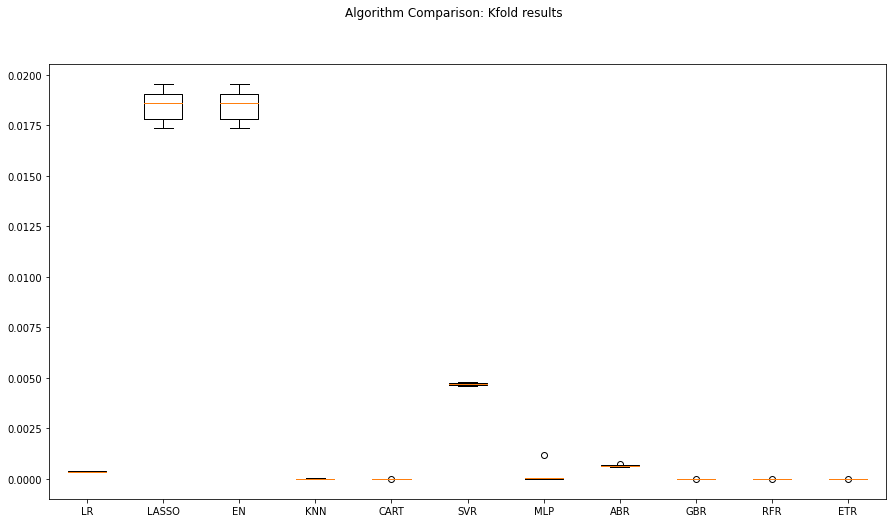

In [21]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

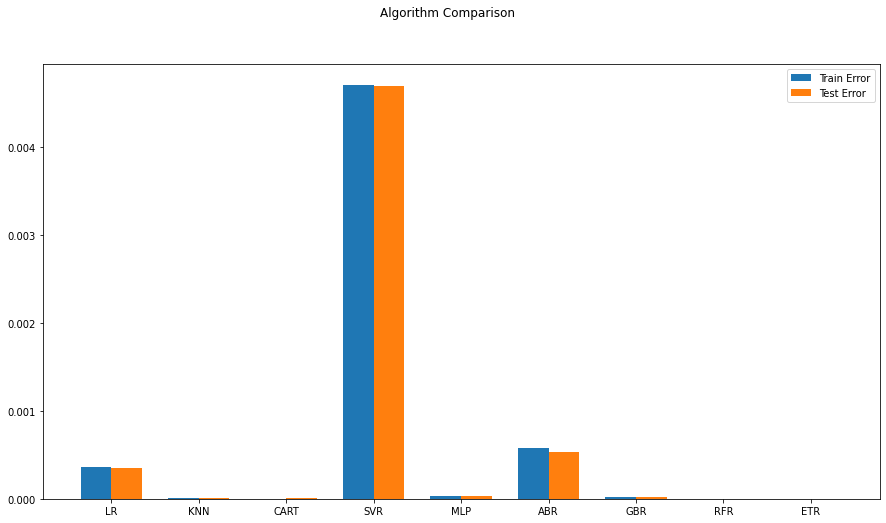

In [22]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

We notice that the non-linear models, including classification and regression tree (CART), ensemble models and ANN perform a lot better than the linear algorithms. \
ANN can be effectively be used in complex derivative pricing situation, out of all the models with good performance, we choose ANN for further analysis.

In [23]:
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000064 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000453 (0.000553) with: {'hidden_layer_sizes': (20,)}
-0.000209 (0.000354) with: {'hidden_layer_sizes': (50,)}
-0.000065 (0.000026) with: {'hidden_layer_sizes': (20, 20)}
-0.000064 (0.000092) with: {'hidden_layer_sizes': (20, 30, 20)}


In [24]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [25]:
# estimate accuracy on validation set
# transform the validation dataset
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

2.7240029061084055e-05


Less than 1 percent error, we see that the ANN model does an excellent job at fitting the Black-Scholes option pricing model